In [21]:
import numpy as np
import pandas as pd
import random
import pickle
from tqdm.notebook import tqdm

import netsurfp2 as nsp2

from structure.utils import AA, to_onehot

In [22]:
AMINO_ACIDS = AA = 'ACDEFGHIKLMNPQRSTVWY'
AA_INDEX = {k:i for i,k in enumerate(AA)}

In [24]:
DATASET = "PF00296"
DATA = "/home/cyril/Documents/These/data"

## PFAM sequence extraction

In [25]:
from structure.data_extraction import from_fasta_to_df, from_df_to_fasta

In [29]:
filename = 'val.fasta'
proteins_df = from_fasta_to_df(f"{DATA}/{DATASET}/{filename}")
proteins_df = proteins_df.drop_duplicates(subset = ["seq"])
proteins_df.seq = proteins_df.aligned_seq.apply(lambda s : "".join([c for c in s if c in AA]))
proteins_df["length"] = proteins_df.seq.apply(lambda seq : len(seq))
# from_df_to_fasta(proteins_df, f"{DATA}/{DATASET}")

In [19]:
proteins_df.seq

E9PLS8_HUMAN/58-87           LPGEWKPCQDITGDIYYFNFANGQSMWDHP
A0A183TN47_SCHSO/124-154    LAFPWIELKSSKTGQFYYFNRNSNVSTYTLP
A0A061IVY0_TRYRA/71-100      LPEHWKACRSEKGELYYFNFKTGESNWDHP
PR40A_ARATH/187-215           ASDWQEHTSADGRKYYYNKRTKQSNWEKP
A0A087VL44_BALRE/190-219     LPKNWEMAYTDTGMIYFIDHNTKTTTWLDP
                                         ...               
E2RA27_CANLF/24-53           LPPGWEIKIDPQTGWPFFVDHNSRTTTWND
H0VJT2_CAVPO/8-37            LPESWEEARDFDGKVYYIDHTNRTTSWIDP
A0A1S3WD67_ERIEU/164-191       NVWVEGLSEDGHTYYYNTETGESRWEKP
A0A0D0CA27_9AGAR/599-628     LPASWEHCTTPLSRTYYINFNTKTTTWNRP
A0A067PJI1_9HOMO/384-413     LPAGWEMRLTSTGKIYFVDHNTRTTTFDDP
Name: seq, Length: 9904, dtype: object

In [30]:
pickle.dump(np.array([[AA_INDEX.get(x,20) for x in seq] for seq in list(proteins_df.aligned_seq)]), open(f"{DATA}/{DATASET}/val.pkl", "wb"))
# pickle.dump([np.array([AA_INDEX[x] for x in seq]) for seq in list(proteins_df.seq)], open(f"{DATA}/{DATASET}/raw.pkl", "wb"))

In [41]:
pickle.dump(list(proteins_df.index), open(f"{DATA}/{DATASET}/keys.pkl", "wb"))

## Build HMM profile

In [9]:
from structure.data_extraction import process_msa

In [7]:
!hhmake -i "{DATA}/{DATASET}/aligned.fasta" -M 100

- 16:50:34.460 INFO: /home/cyril/Documents/These/data/PF00397/aligned.fasta is in A2M, A3M or FASTA format

- 16:50:34.487 INFO: NOTE: Use the '-add_cons' option to calculate a consensus sequence as first sequence of the alignment with hhconsensus or hhmake.



In [11]:
with open(f"{DATA}/{DATASET}/aligned.fasta") as f:
    protlist = nsp2.parse_fasta(f)
new_protlist = dict()
for k,v in protlist.items():
    if k.split("_")[1] == "P42212":
        new_protlist[k]= v
protlist = new_protlist
uni_idx = [x.split("_")[1] for x in protlist.keys()]

In [12]:
hhm_name = f"{DATA}/{DATASET}/aligned.hhm"
dataset = dict()
# protlist = {k:v for k,v in random.sample(protlist.items(), 2000)}
for k,(_,v) in tqdm(protlist.items()):
    prof = process_msa(v, hhm_name)["profile"]
    idx = np.where(prof[:,:20].sum(1))
    dataset[k] = prof[idx]

A Jupyter Widget

In [35]:
pickle.dump(dataset, open(f"{DATA}/{DATASET}/hmm.pkl", "wb"))

In [14]:
AMINO_ACIDS = AA = 'ACDEFGHIKLMNPQRSTVWY*'
AA_INDEX = {k:i for i,k in enumerate(AA)}

### GFP

In [4]:
S = "MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTFSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK"
S = [c for c in S]

df = pd.read_csv(f"{DATA}/{DATASET}/amino_acid_genotypes_to_brightness.tsv", sep = "\t")
nodes = ["".join(S)]
for x in df.aaMutations.values:
    seq = S.copy()
    if type(x) is not str:
        continue
    for mut in x.split(":"):
        aa, pos = mut[-1], int(mut[2:-1])+1
        seq[pos] = aa
    nodes.append("".join(seq))
df["seq"] = nodes
df.seq = df.seq.apply(lambda s : s[5:-11])

In [33]:
df

,aaMutations,uniqueBarcodes,medianBrightness,std,seq
0,NaN,3645,3.719212,0.106992,ELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTG...
1,SA108D,1,1.301030,NaN,ELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTG...
2,SA108D:SN144D:SI186V:SM231T:SL234P,1,1.301031,NaN,ELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTG...
3,SA108D:SY141N:SH146L:SE220G,1,1.301189,NaN,ELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTG...
4,SA108G,2,3.708478,0.020613,ELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTG...
...,...,...,...,...,...
54020,SY90N:SN103S:SI169F,1,1.552090,NaN,ELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTG...
54021,SY90N:SQ175L:SL205Q:ST228A:SM231V,1,1.301030,NaN,ELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTG...
54022,SY90R:SI150N:SN196S,1,1.301030,NaN,ELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTG...
54023,SY90R:SI165T:SL234P,1,1.301517,NaN,ELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTG...


In [15]:
HMM = dataset['0012_P42212_6-227']
hmms = []
for i, s in enumerate(df.seq.values):
    seq = to_onehot([AA_INDEX[x] for x in s], (None,21))
    idx = np.where(np.argmax(seq,1) != 20)[0]
    hmm = np.copy(HMM)
    hmm[:,:20] = seq[:,:20]
    hmm = hmm[idx]
    hmms.append(hmm)

In [16]:
hmms = np.array([[AA_INDEX[x] for x in s] for s in df.seq.values])

In [36]:
from sklearn.neighbors import kneighbors_graph
g = kneighbors_graph(hmms, 5, mode = "distance", metric = "hamming")

In [37]:
import networkx as nx
G = nx.Graph(g)

In [11]:
pickle.dump({f"{i}_bright_{k}":v for i,(k,v) in enumerate(zip(df.medianBrightness, hmms))}, 
            open(f"{DATA}/{DATASET}/hmm_spec.pkl", "wb"))

## Secondary Structure Extraction

In [10]:
pdb_to_uniprot = pd.read_csv(f"{DATA}/cross/uniprot_pdb.csv", skiprows = 2, names = ["uni","pdb"])
uni = []
pdb = []
i = 0
for x in pdb_to_uniprot.itertuples():
    for pdbid in x.pdb.split(";"):
        pdb.append(str.upper(pdbid))
        uni.append(x.uni)
        
pdb_uniprot = pd.DataFrame(columns = ["uni", "pdb"])
pdb_uniprot["uni"] = uni
pdb_uniprot["pdb"] = pdb
pdb_uniprot = pdb_uniprot.drop_duplicates("pdb")
pdb_uniprot.index = pdb_uniprot.pdb 
del pdb_to_uniprot

In [11]:
mapping = pd.read_table(f"{DATA}/cross/pdb_to_pfam.txt")
mapping["PFAM_ID"] = mapping.PFAM_ACC.apply(lambda x : x.split(".")[0])
fam = mapping[mapping.PFAM_ID == DATASET]
structfam = dict()
for x in fam.itertuples():
    try:
        structfam[pdb_uniprot.loc[x.PDB_ID].uni]= (x.PDB_ID, 
                          pdb_uniprot.loc[x.PDB_ID].uni, 
                          x.CHAIN_ID, 
                          int(x.PdbResNumStart), 
                          int(x.PdbResNumEnd))
    except:
        print(x)

Pandas(Index=86021, PDB_ID='2NC6', CHAIN_ID='A', PdbResNumStart='2', PdbResNumEnd='31', PFAM_ACC='PF00397.25', PFAM_Name='WW', PFAM_desc='WW domain', eValue=3.6e-11, PFAM_ID='PF00397')
Pandas(Index=90862, PDB_ID='1E0M', CHAIN_ID='A', PdbResNumStart='4', PdbResNumEnd='33', PFAM_ACC='PF00397.25', PFAM_Name='WW', PFAM_desc='WW domain', eValue=8.4e-13, PFAM_ID='PF00397')
Pandas(Index=137466, PDB_ID='2NC3', CHAIN_ID='A', PdbResNumStart='2', PdbResNumEnd='31', PFAM_ACC='PF00397.25', PFAM_Name='WW', PFAM_desc='WW domain', eValue=3.6e-11, PFAM_ID='PF00397')
Pandas(Index=171206, PDB_ID='2NC5', CHAIN_ID='A', PdbResNumStart='2', PdbResNumEnd='31', PFAM_ACC='PF00397.25', PFAM_Name='WW', PFAM_desc='WW domain', eValue=3.6e-11, PFAM_ID='PF00397')
Pandas(Index=186450, PDB_ID='2NC4', CHAIN_ID='A', PdbResNumStart='2', PdbResNumEnd='31', PFAM_ACC='PF00397.25', PFAM_Name='WW', PFAM_desc='WW domain', eValue=3.6e-11, PFAM_ID='PF00397')
Pandas(Index=226508, PDB_ID='1YMZ', CHAIN_ID='A', PdbResNumStart='3', Pd

In [12]:
structfam

{'Q8C863': ('1YIU', 'Q8C863', 'A', 6, 35),
 'Q96PU5': ('2MPT', 'Q96PU5', 'A', 479, 508),
 'Q13526': ('5VTJ', 'Q13526', 'A', 7, 37),
 'O15105': ('2LTV', 'O15105', 'A', 232, 261),
 'P08050': ('2N8T', 'P08050', 'A', 6, 35),
 'Q96QZ7': ('2YSE', 'Q96QZ7', 'A', 14, 43),
 'O00308': ('6RSS', 'O00308', 'A', 75, 104),
 'Q96J02': ('5CQ2', 'Q96J02', 'A', 480, 509),
 'P46937': ('5YDX', 'P46937', 'A', 16, 45),
 'O14776': ('2MWF', 'O14776', 'A', 434, 460),
 'P84022': ('2LB2', 'P84022', 'A', 367, 396),
 'Q8CFI0': ('1WR7', 'Q8CFI0', 'A', 9, 38),
 'O00213': ('2OEI', 'O00213', 'A', 255, 283),
 'O75400': ('1YWI', 'O75400', 'A', 17, 42),
 'Q15797': ('2LB0', 'Q15797', 'A', 236, 265),
 'Q9BYW2': ('2MDI', 'Q9BYW2', 'A', 17, 46),
 'P46934': ('4N7F', 'P46934', 'A', 423, 452),
 'Q9NZC7': ('1WMV', 'Q9NZC7', 'A', 12, 41),
 'O75554': ('2DK1', 'O75554', 'A', 9, 34),
 'P11532': ('1EG4', 'P11532', 'A', 59, 86),
 'Q9H4Z3': ('2JX8', 'Q9H4Z3', 'A', 7, 36),
 'Q05860': ('2RLY', 'Q05860', 'W', 6, 33),
 'Q9H0M0': ('6J1X', 'Q

In [13]:
mapping[mapping.PFAM_ID == DATASET].PDB_ID == "1EMA"

4669      False
4670      False
4671      False
6360      False
10948     False
          ...  
321649    False
321650    False
321942    False
321943    False
323399    False
Name: PDB_ID, Length: 204, dtype: bool

## Pattern Builds

In [15]:
from structure.data_extraction import fetch_PDB

In [17]:
from structure.utils import *

patterns = dict()
for pdb, pfam, c, start, end in structfam.values():
    try:
        sse, tk_mono = fetch_PDB(pdb, c, start, end+1)
        ss = to_onehot([abc_codes[x] for x in sse], (None,3))
        ss = np.pad(ss, ((1,1),(0,0)), "constant")
        dss = (ss[1:] - ss[:-1])
        cls = to_onehot(np.where(dss == -1)[1], (None, 3)).T
        bbox = np.array([np.where(dss == 1)[0], np.where(dss == -1)[0], *cls]).T
        patterns[pfam] = np.argmax(bbox[:,2:],1)
    except:
        print(pdb, pfam, c, start, end)

5CQ2 Q96J02 A 480 509
6J1X Q9H0M0 B 506 535


In [18]:
fetch_PDB("1EMA", "A", 5, 1000)[0].shape

(220,)

In [19]:
structfam["P42212"] = pdb, pfam, c, start, end
sse, tk_mono = fetch_PDB(pdb, c, start, end+1)
ss = to_onehot([abc_codes[x] for x in sse], (None,3))
ss = np.pad(ss, ((1,1),(0,0)), "constant")
dss = (ss[1:] - ss[:-1])
cls = to_onehot(np.where(dss == -1)[1], (None, 3)).T
bbox = np.array([np.where(dss == 1)[0], np.where(dss == -1)[0], *cls]).T
patterns[pfam] = np.argmax(bbox[:,2:],1)

In [20]:
pdb

'6JJZ'

In [24]:
n_patterns = []
c_patterns = []
for k,pat in patterns.items():
#     if k not in uni_idx:
#         continue
    print(str(structfam[k])+" :")
    char_pat= "".join(["abc"[x] for x in pat])
    if len(char_pat) and char_pat not in c_patterns:
        c_patterns.append(char_pat)
        n_patterns.append(list(pat))

('1YIU', 'Q8C863', 'A', 6, 35) :
('2MPT', 'Q96PU5', 'A', 479, 508) :
('5VTJ', 'Q13526', 'A', 7, 37) :
('2LTV', 'O15105', 'A', 232, 261) :
('2N8T', 'P08050', 'A', 6, 35) :
('2YSE', 'Q96QZ7', 'A', 14, 43) :
('6RSS', 'O00308', 'A', 75, 104) :
('5YDX', 'P46937', 'A', 16, 45) :
('2MWF', 'O14776', 'A', 434, 460) :
('2LB2', 'P84022', 'A', 367, 396) :
('1WR7', 'Q8CFI0', 'A', 9, 38) :
('2OEI', 'O00213', 'A', 255, 283) :
('1YWI', 'O75400', 'A', 17, 42) :
('2LB0', 'Q15797', 'A', 236, 265) :
('2MDI', 'Q9BYW2', 'A', 17, 46) :
('4N7F', 'P46934', 'A', 423, 452) :
('1WMV', 'Q9NZC7', 'A', 12, 41) :
('2DK1', 'O75554', 'A', 9, 34) :
('1EG4', 'P11532', 'A', 59, 86) :
('2JX8', 'Q9H4Z3', 'A', 7, 36) :
('2RLY', 'Q05860', 'W', 6, 33) :
('3OLM', 'P0CG63', 'A', 389, 418) :
('2EZ5', 'Q24139', 'W', 531, 560) :
('2JV4', 'Q5AZY5', 'A', 7, 37) :
('2L4J', 'E7FH70', 'A', 188, 217) :
('2YSB', 'Q8VEB2', 'A', 12, 41) :
('2N8S', 'Q62940', 'A', 6, 35) :
('1I8G', 'P30311', 'B', 2, 32) :
('2YSC', 'O95704', 'A', 9, 37) :
('2M

In [26]:
pickle.dump((n_patterns, c_patterns, list(patterns.keys())), open(f"{DATA}/{DATASET}/patterns.pkl", "wb"))

## Vizualization

In [5]:
from structure.graphics import visualize_secondary_structure
from structure.data_extraction import fetch_PDB
import matplotlib.pyplot as plt

1YIU


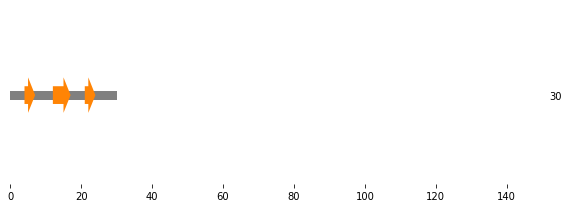

2MPT
2MPT Q96PU5 A 479 509
5VTJ


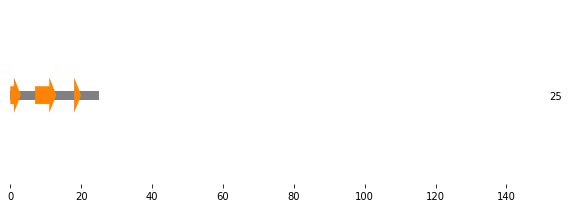

2LTV
2LTV O15105 A 232 262
2N8T


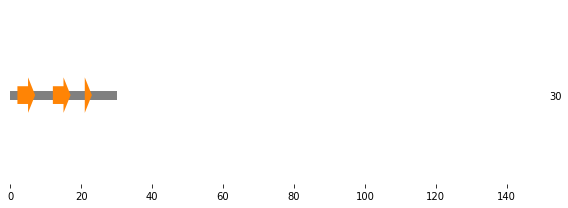

2YSE


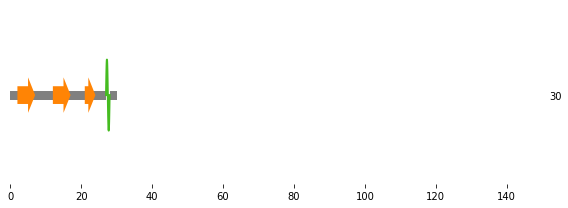

6RSS


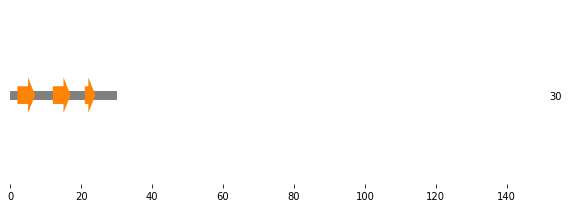

5CQ2
5CQ2 Q96J02 A 480 510
5YDX


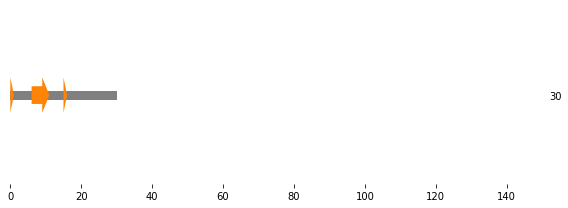

2MWF
2MWF O14776 A 434 461
2LB2
2LB2 P84022 A 367 397
1WR7


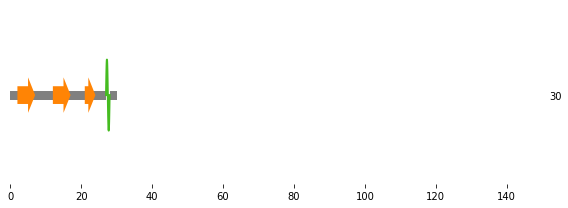

2OEI
2OEI O00213 A 255 284
1YWI


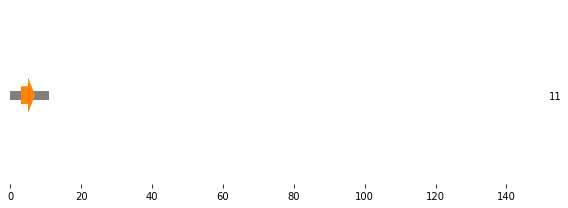

2LB0
2LB0 Q15797 A 236 266
2MDI


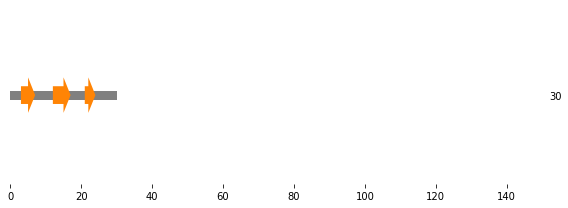

4N7F
4N7F P46934 A 423 453
1WMV


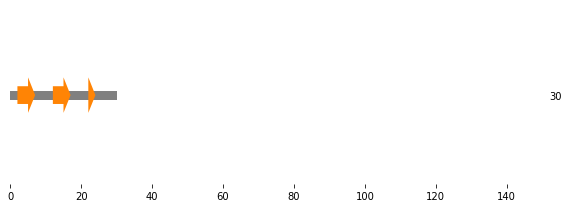

2DK1


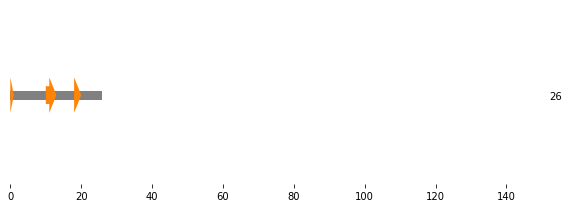

1EG4


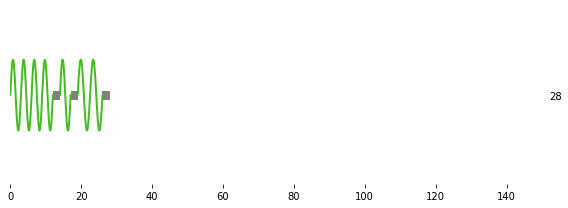

2JX8


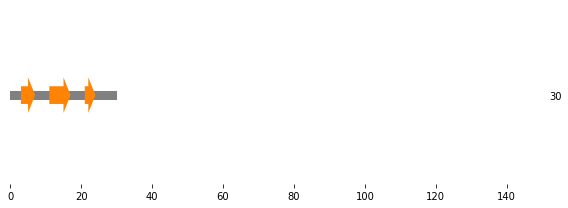

2RLY


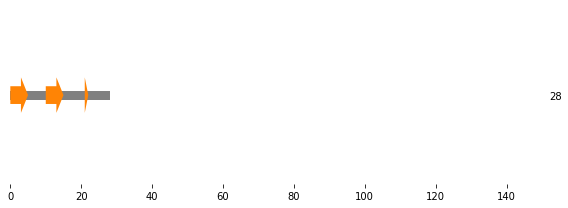

6J1X
6J1X Q9H0M0 B 506 536
3OLM


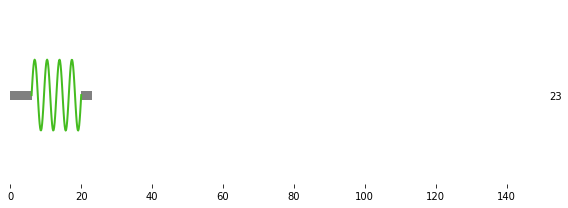

2EZ5
2EZ5 Q24139 W 531 561
2JV4


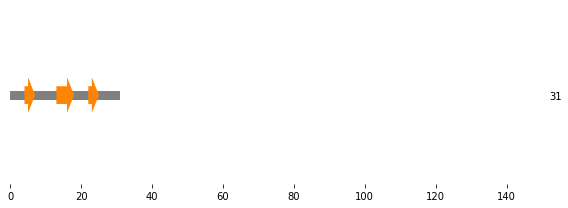

2L4J
2L4J E7FH70 A 188 218
2YSB


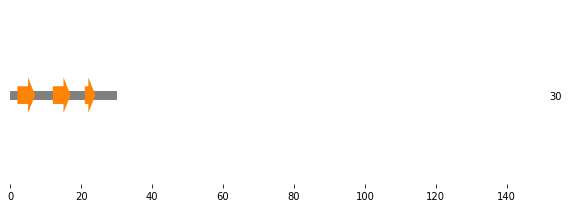

2N8S


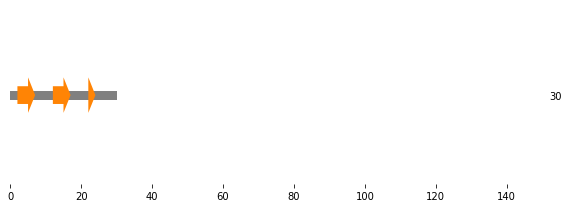

1I8G


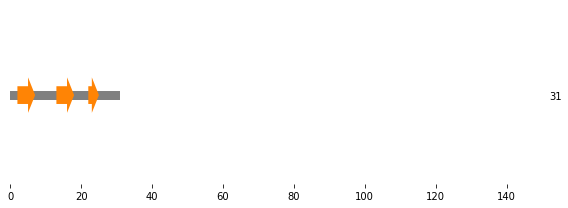

2YSC


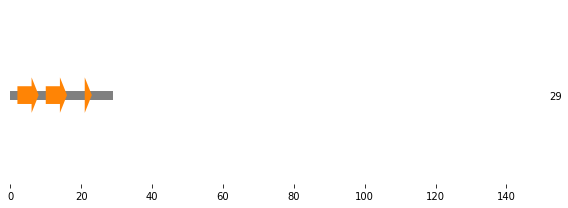

2M3O
2M3O P37088 W 423 453
1YW5


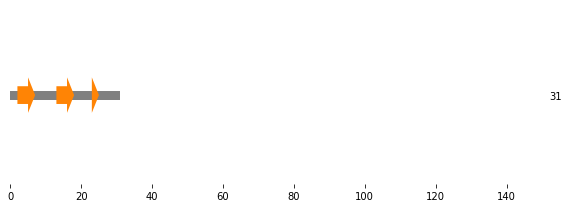

2JO9


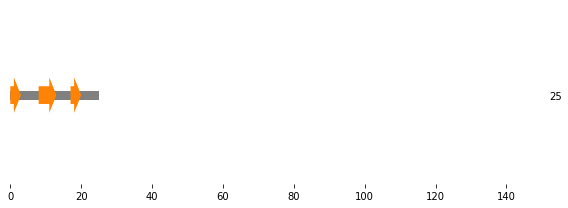

4LCD


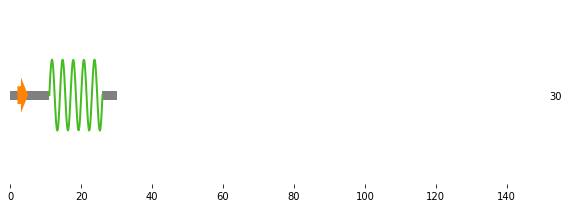

1E0L


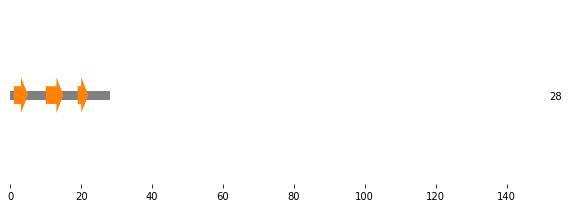

5B3Z


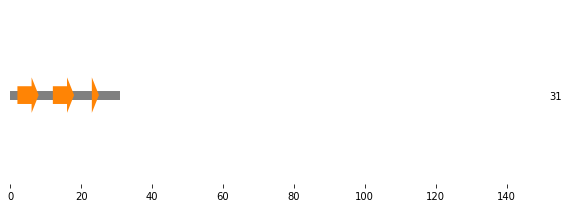

2JMF
2JMF Q32UW5 A 523 553
3L4H
3L4H Q76N89 A 1020 1050
1I5H
1I5H P37090 W 461 491
1I8H


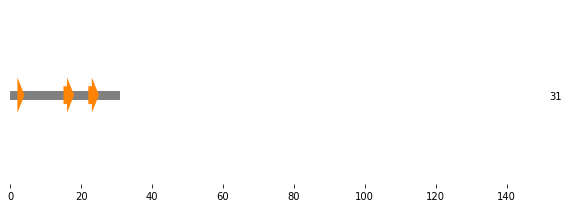

2YSG


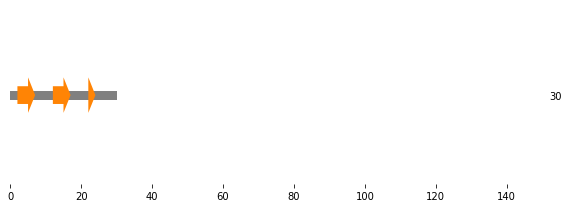

2KPZ


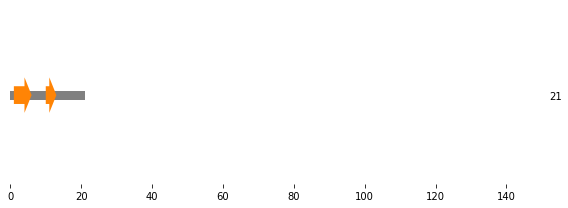

1O6W


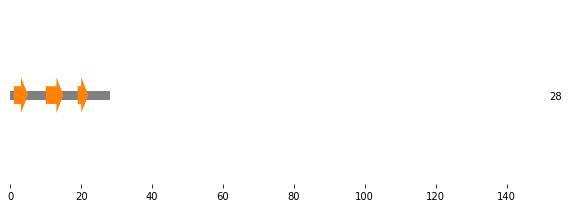

2YSH


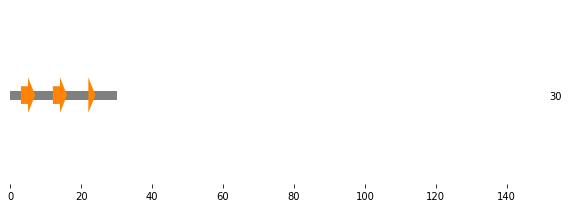

1TK7


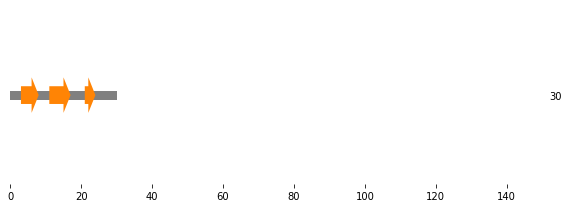

6J68


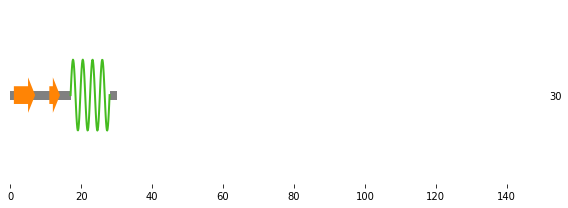

6N7P
6N7P P32605 J 397 425
6JJW


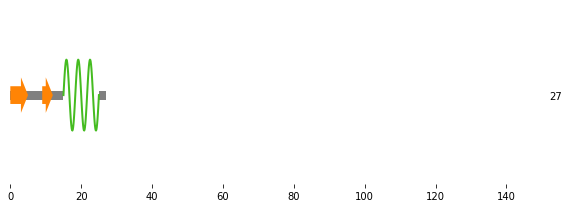

6JJY


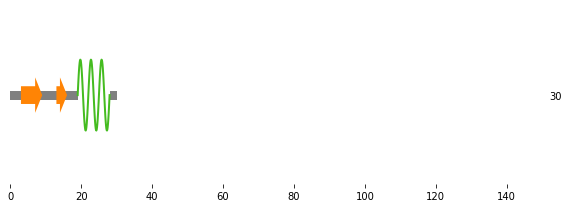

6JK1
6JK1 P46938 A 219 249
6JJX


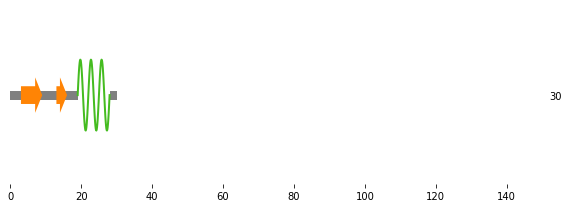

6JJZ
6JJZ Q80TS7 A 360 390
6JJZ
6JJZ Q80TS7 A 360 390


In [29]:
for pdb, pfam, c, start, end in structfam.values():
    try:
        print(pdb)
        sse, tk_mono = fetch_PDB(pdb, c, start, end+1)
        visualize_secondary_structure(sse, 0, 150)
        plt.show()
    except:
        print(pdb, pfam, c, start, end+1)

In [6]:
fetch_PDB('1YIU', 'A', 6, 35)

(array(['c', 'c', 'c', 'c', 'c', 'b', 'b', 'b', 'c', 'c', 'c', 'c', 'c',
        'b', 'b', 'b', 'b', 'b', 'c', 'c', 'c', 'c', 'b', 'b', 'b', 'c',
        'c', 'c', 'c'], dtype='<U1'),
 <biotite.structure.AtomArray at 0x7f2e04c0a310>)

In [1]:
from biotite.structure.io.pdb import get_structure

In [2]:
get_structure('1YIU', 'A', 6, 35)

AttributeError: 'str' object has no attribute 'get_structure'